# Load libraries :

In [7]:
import keras

In [8]:
import pickle

In [9]:
# Import comet_ml at the top of your file, before sklearn!
from comet_ml import Experiment
import os 
from sklearn.metrics import accuracy_score

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

In [11]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# for modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [12]:
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [13]:
%load_ext autoreload
%autoreload 2
from ift6758.data.Feature_Engineering1 import combineAllFeatures
from ift6758.data.Feature_Engineering2 import tidyData, getPreviousEvent

# EDA :

In [72]:
df = pd.read_csv('featureEng_Train_set1.csv')

In [15]:
tidyData(2019)
df_2019_2020 = pd.read_csv('./2019Milestone2Dataset.csv')
test_set = combineAllFeatures(df_2019_2020)
test_set = getPreviousEvent(test_set)

file already exsiste


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/khadidjabourega/Documents/Fall_2022/Data_Science/Projects/Project2/IFT6758_project1-milestone-2/ift6758/data/Feature_Engineering2.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_from_last_event'] = df['periodSeconds'] - df['last_periodSeconds']
/Users/khadidjabourega/Documents/Fall_2022/Data_Science/Projects/Project2/IFT6758_project1-milestone-2/ift6758/data/Feature_Engineering2.py:130: SettingWithCopyWarni

In [27]:
test_set.head()

,gameID,eventType,period,periodTime,periodType,teamOfShooter,homeOrAway,xCoord,yCoord,shooter,...,last_eventyCoord,last_shotType,last_periodSeconds,last_Distance_from_net,last_Angle_from_net,time_from_last_event,distance_from_last_event,rebound,change_in_angle,speed
4,2019020001,Goal,1,00:25,REGULAR,Ottawa Senators,away,85.0,-1.0,Brady Tkachuk,...,0.0,NaN,0.0,89.000000,0.000000,25.0,85.005882,False,0.0,3.400235
12,2019020001,Shot,1,01:31,REGULAR,Toronto Maple Leafs,home,-32.0,-2.0,Morgan Rielly,...,-31.0,NaN,64.0,61.400326,30.323607,27.0,29.274562,False,0.0,1.084243
19,2019020001,Shot,1,03:23,REGULAR,Ottawa Senators,away,63.0,-6.0,Dylan DeMelo,...,-4.0,NaN,189.0,25.317978,9.090277,14.0,127.015747,False,0.0,9.072553
22,2019020001,Shot,1,03:56,REGULAR,Toronto Maple Leafs,home,-59.0,-20.0,Morgan Rielly,...,-20.0,NaN,230.0,58.523500,19.983107,6.0,93.000000,False,0.0,15.500000
27,2019020001,Shot,1,04:47,REGULAR,Toronto Maple Leafs,home,-42.0,-29.0,Tyson Barrie,...,4.0,NaN,281.0,5.000000,53.130102,6.0,55.000000,False,0.0,9.166667


# Regular vs Playoff data :

In [40]:
test_set_regular = test_set[test_set['gameID'].astype(str).str.startswith('201902')]
test_set_playoff = test_set[test_set['gameID'].astype(str).str.startswith('201903')]

CHeking for missing values : 

In [41]:
test_set_regular= test_set_regular[['period','periodType','teamOfShooter','shotType','empty_Net','Distance_from_net','Angle_from_net','time_from_last_event','distance_from_last_event','rebound','change_in_angle','speed','Is_goal']]
test_set_playoff= test_set_playoff[['period','periodType','teamOfShooter','shotType','empty_Net','Distance_from_net','Angle_from_net','time_from_last_event','distance_from_last_event','rebound','change_in_angle','speed','Is_goal']]

In [42]:
test_set_regular.dropna(inplace = True)
test_set_playoff.dropna(inplace = True)

In [45]:
test_set_playoff.periodType.unique()

array(['REGULAR', 'OVERTIME'], dtype=object)

# Feature encoding :

In [46]:
test_set_regular[['periodType_OVERTIME','periodType_REGULAR','periodType_SHOOTOUT' ]] = pd.get_dummies(test_set_regular[['periodType']])
test_set_playoff[['periodType_OVERTIME','periodType_REGULAR' ]] = pd.get_dummies(test_set_playoff[['periodType']])

In [47]:
encoder = ce.LeaveOneOutEncoder(return_df=True)
test_set_regular['teamOfShooter'] = encoder.fit_transform(test_set_regular['teamOfShooter'], test_set_regular['Is_goal'])
test_set_playoff['teamOfShooter'] = encoder.fit_transform(test_set_playoff['teamOfShooter'], test_set_playoff['Is_goal'])

In [48]:
from sklearn.preprocessing import OrdinalEncoder
# define ordinal encoding
encoder = OrdinalEncoder(categories=[['Slap Shot', 'Wrap-around','Wrist Shot','Snap Shot','Backhand','Deflected','Tip-In']])
# transform data
test_set_regular["shotType"] = encoder.fit_transform(test_set_regular[["shotType"]])
test_set_playoff["shotType"] = encoder.fit_transform(test_set_playoff[["shotType"]])

In [49]:
test_set_regular =test_set_regular.drop(['periodType','periodType_SHOOTOUT'], axis=1)
test_set_playoff =test_set_playoff.drop(['periodType'], axis=1)

# Feature selection :

In [51]:
X_regular = test_set_regular[['teamOfShooter','shotType','empty_Net','Distance_from_net','Angle_from_net','time_from_last_event','distance_from_last_event','change_in_angle','speed']]
X_playoff = test_set_playoff[['teamOfShooter','shotType','empty_Net','Distance_from_net','Angle_from_net','time_from_last_event','distance_from_last_event','change_in_angle','speed']]
y_regular = test_set_regular['Is_goal']  
y_playoff = test_set_playoff['Is_goal']  

# Data standarisation :

In [52]:
scaler = StandardScaler()
X_regular = scaler.fit_transform(X_regular)
y_regular = y_regular.values
X_playoff = scaler.fit_transform(X_playoff)
y_playoff = y_playoff.values

# DOWNLOAD THE MODEL :

In [107]:
#from comet_ml import API

#api = API(api_key="LgN3RhQfuVAcQnKyC9X0Gk1PC")

#experiment = api.get("yasmine/ift6758-a22-milestone-2/neural network - best param - smote method")
#experiment.register_model("Try best shot6")

In [103]:
from comet_ml import API

api = API(api_key="LgN3RhQfuVAcQnKyC9X0Gk1PC")
filename = '../models/try-best-shot5.sav'
experiment = api.get("yasmine/ift6758-a22-milestone-2/final model")

# Download an Experiment Model:
experiment.download_model("Try best shot6", output_path="../models", expand=True)

# Download a Registry Model:
api.download_registry_model("yasmine", "try-best-shot6", "1.0.0",
                            output_path="../models", expand=True)

COMET INFO: Downloading experiment model 'Try best shot6' ...
COMET INFO: Unzipping model to '../models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'try-best-shot6', version '1.0.0', stage None from workspace 'yasmine'...
COMET INFO: Unzipping model to '/Users/khadidjabourega/Documents/Fall_2022/Data_Science/Projects/Project2/IFT6758_project1-milestone-2/models' ...
COMET INFO: done!


In [104]:
from joblib import load
Neural_netowrk = load('../models/TryBestShot_bestmodel.sav')

2118/2118 [==============================] - 1s 413us/step


# REGULAR DATA RESULTS :

In [128]:
preds_reg = Neural_netowrk.predict(X_regular)
# see how these are numbers between 0 and 1? 
Neural_netowrk.predict(X_regular) # prob of successes 
np.round(Neural_netowrk.predict(X_regular),0) # 1 and 0 
y_regular # 1 and 0 (survival or not)

preds = np.round(Neural_netowrk.predict(X_regular),0)

# confusion matrix
print(confusion_matrix(y_regular, preds))

print(classification_report(y_regular, preds))

2118/2118 [==============================] - 1s 382us/step
[[49334 11848]
 [ 2997  3581]]
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     61182
           1       0.23      0.54      0.33      6578

    accuracy                           0.78     67760
   macro avg       0.59      0.68      0.60     67760
weighted avg       0.87      0.78      0.82     67760



In [120]:
y_proba_val_REG = Neural_netowrk.predict(X_regular)
y_proba_val_REG = np.concatenate([y_regular for y_regular in y_proba_val_REG], axis=0)
y_proba_val_REG

2118/2118 [==============================] - 1s 401us/step


array([0.69146496, 0.0750436 , 0.50440025, ..., 0.45524508, 0.6036221 ,
       0.43931317], dtype=float32)

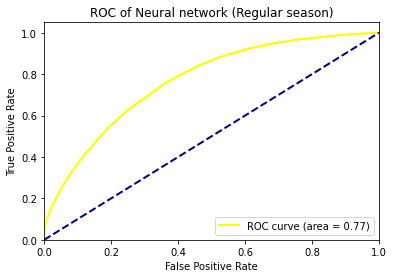

In [121]:
from sklearn.metrics import roc_curve, auc


a, b, _ = roc_curve(y_regular, y_proba_val_REG)
roc_auc_d = auc(a, b)
plt.figure()
plt.plot(
    a,
    b,
    color="yellow",
    lw=2,
    label="ROC curve (area = %0.2f)" % roc_auc_d,
)
xy=[0, 1]
plt.plot(xy, xy, color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC of Neural network (Regular season)")
plt.legend(loc="lower right")

plt.savefig('../figures/q71_NN_ROC_regular.png')
plt.show()

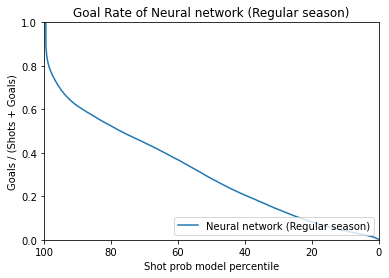

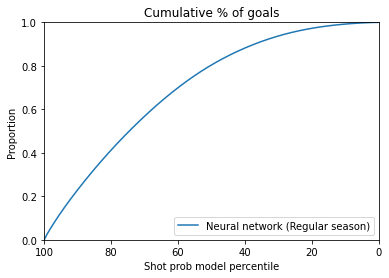

In [113]:
#model percentile
iu = y_proba_val_REG
n = len(iu)
x_axis = np.arange(n)[::-1]*(100/n)
#print(x_axis)

iu_y = iu[::-1]
iu_y[::-1].sort()
# print(sum(lr_probs_y))
#print(lr_probs_y)
iu_y_sum = np.cumsum(iu_y)


plt.figure()
plt.plot(
    x_axis,
    iu_y,
    label = 'Neural network (Regular season)'
)
plt.xlim([100, 0])
plt.ylim([0.0, 1.0])
plt.xlabel("Shot prob model percentile")
plt.ylabel("Goals / (Shots + Goals)")
plt.title("Goal Rate of Neural network (Regular season)")
plt.legend(loc="lower right")
plt.savefig('../figures/q71_NN.png')
plt.show()

#cumulative plot
plt.figure()
plt.plot(
    x_axis,
    iu_y_sum/sum(iu_y),
    label = 'Neural network (Regular season)'
)
plt.xlim([100, 0])
plt.ylim([0.0, 1.0])
plt.xlabel("Shot prob model percentile")
plt.ylabel("Proportion")
plt.title("Cumulative % of goals")
plt.legend(loc="lower right")
plt.savefig('../figures/q71_nn_CP_Regular_season.png')
plt.show()

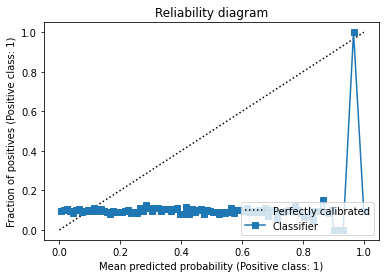

In [114]:
from sklearn.calibration import CalibrationDisplay
disp = CalibrationDisplay.from_predictions(y_regular, y_proba_val_REG,n_bins=100)
plt.title("Reliability diagram")
plt.savefig('../figures/71_NN_Reliability_diagram_regular_season.png')
plt.show()

# PLAYOFF DATA RESULTS :

In [115]:
preds_reg = Neural_netowrk.predict(X_playoff)
# see how these are numbers between 0 and 1? 
Neural_netowrk.predict(X_playoff) # prob of successes 
np.round(Neural_netowrk.predict(X_playoff),0) # 1 and 0 
y_playoff # 1 and 0 (survival or not)

preds = np.round(Neural_netowrk.predict(X_playoff),0)

# confusion matrix
print(confusion_matrix(y_playoff, preds))

print(classification_report(y_playoff, preds))

153/153 [==============================] - 0s 408us/step
[[3601  848]
 [ 317  117]]
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      4449
           1       0.12      0.27      0.17       434

    accuracy                           0.76      4883
   macro avg       0.52      0.54      0.51      4883
weighted avg       0.85      0.76      0.80      4883



In [124]:
y_proba_val_POFF = Neural_netowrk.predict(X_playoff)
y_proba_val_POFF = np.concatenate([y_playoff for y_playoff in y_proba_val_POFF], axis=0)
y_proba_val_POFF

153/153 [==============================] - 0s 429us/step


array([0.7699082 , 0.3177149 , 0.43604204, ..., 0.05858918, 0.19858828,
       0.00816998], dtype=float32)

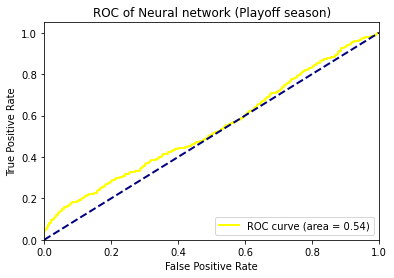

In [125]:
from sklearn.metrics import roc_curve, auc


a, b, _ = roc_curve(y_playoff, y_proba_val_POFF)
roc_auc_d = auc(a, b)
plt.figure()
plt.plot(
    a,
    b,
    color="yellow",
    lw=2,
    label="ROC curve (area = %0.2f)" % roc_auc_d,
)
xy=[0, 1]
plt.plot(xy, xy, color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC of Neural network (Playoff season)")
plt.legend(loc="lower right")

plt.savefig('../figures/q71_NN_ROC_playoff.png')
plt.show()

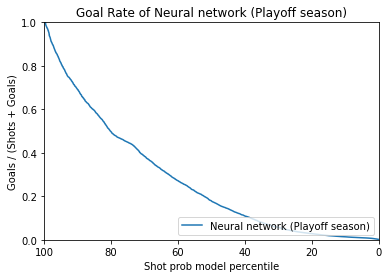

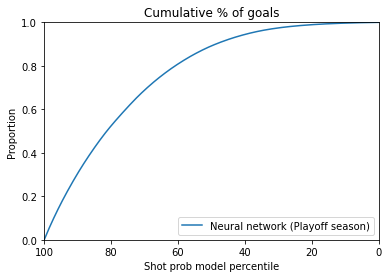

In [126]:
#model percentile
iu = y_proba_val_POFF
n = len(iu)
x_axis = np.arange(n)[::-1]*(100/n)
#print(x_axis)

iu_y = iu[::-1]
iu_y[::-1].sort()
# print(sum(lr_probs_y))
#print(lr_probs_y)
iu_y_sum = np.cumsum(iu_y)


plt.figure()
plt.plot(
    x_axis,
    iu_y,
    label = 'Neural network (Playoff season)'
)
plt.xlim([100, 0])
plt.ylim([0.0, 1.0])
plt.xlabel("Shot prob model percentile")
plt.ylabel("Goals / (Shots + Goals)")
plt.title("Goal Rate of Neural network (Playoff season)")
plt.legend(loc="lower right")
plt.savefig('../figures/q71_NN_playoff.png')
plt.show()

#cumulative plot
plt.figure()
plt.plot(
    x_axis,
    iu_y_sum/sum(iu_y),
    label = 'Neural network (Playoff season)'
)
plt.xlim([100, 0])
plt.ylim([0.0, 1.0])
plt.xlabel("Shot prob model percentile")
plt.ylabel("Proportion")
plt.title("Cumulative % of goals")
plt.legend(loc="lower right")
plt.savefig('../figures/q71_nn_CP_playoff_season.png')
plt.show()

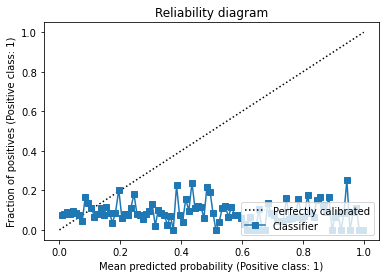

In [127]:
from sklearn.calibration import CalibrationDisplay
disp = CalibrationDisplay.from_predictions(y_playoff, y_proba_val_POFF,n_bins=100)
plt.title("Reliability diagram")
plt.savefig('../figures/71_NN_Reliability_diagram_playoff_season.png')
plt.show()